In this notebook, we run the stacked predictive scenario for each cognitive score and generate the prediction accuracies, as well as the weight contributions of each single-channel to the LASSO stacked model. As explained in the manuscript, out-of-sample predictions have been achieved using a Montecarlo cross-validation with 100 random splits into training (70% of the total data) and test (30% of the total data) set. 

**This is the R1 version, in which we have removed the effects of intracranel volume from the response variable, added a confounder channel and generated the partitions taking into account the twins info**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from os.path import join as opj
import sys
import time
import h5py

#Sklearn stuff
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import  (StandardScaler, PolynomialFeatures)
from sklearn.linear_model import (Lasso, LassoCV, LinearRegression)
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GroupShuffleSplit

from scipy.stats import ks_2samp

In [2]:
# add src folder from which we can import some customed functions
sys.path.append("/home/javi/Documentos/multimodal-cognition/")

# This is the stacking class
from stacking import StackingLassoCV

In [3]:
RANDOM_STATE = 0

Load the data

In [4]:
f =  h5py.File(opj("../data", "final_data_R1.hdf5"), "r")

# Response  data
YY_domain_cognition =  f['YY_domain_cognition'][:]
# Independent data
X_conn = f['connectome_features'][:]
X_surf = f['surface_features'][:]
X_thic = f['thickness_features'][:]
X_subv = f['sub_vols_features'][:]
X_locc = f['loc_conn_features'][:]

# Confounders
X_conf = f['confounder_features'][:]
icv_var = f['intracv_feature'][:]

# Subjects ID
subjects = f['subjects'][:]
f.close()

Load resctricted data and merge with our subjects

In [5]:
restricted_dat = pd.read_csv("../data/RESTRICTED_frankyeh_8_2_2017_12_54_49.csv")
restricted_dat = pd.merge(pd.DataFrame({'Subject': subjects}), restricted_dat, on='Subject')

create twin labels, so that they then are splitted always together

In [6]:
twins_ixs = restricted_dat[restricted_dat.ZygosityGT!=" "].Family_ID.index
notwins_ixs = restricted_dat[restricted_dat.ZygosityGT==" "].Family_ID.index

In [7]:
len(twins_ixs)

419

In [8]:
len(notwins_ixs)

609

In [9]:
# The twins are labelled identically, equally to the family ID. Non twins are labelled according to the Subject ID
from sklearn.preprocessing import LabelEncoder
group_label = []
for ix in restricted_dat.index:
    if ix in twins_ixs:
        group_label.append(restricted_dat.loc[ix, "Family_ID"])
    else:
        group_label.append(restricted_dat.loc[ix, "Subject"])      

group_label = LabelEncoder().fit_transform(group_label)

In [10]:
# Check that Subject IDs and Family IDs are different, so that we are not reintrod
sum(np.in1d(restricted_dat.Subject, restricted_dat.Family_ID))

/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0

In [13]:
# Number of "independent" subjects
print(len(np.unique(group_label)))

print(len(restricted_dat.loc[notwins_ixs, "Subject"].unique()) + len(restricted_dat.loc[twins_ixs, "Family_ID"].unique()))

837
837


In [14]:
# These is the number of affected observations
sum(np.unique(group_label, return_counts=True)[1]==2)

191

mask all the data to exclude this subject

In [15]:
prepend_transformation = [VarianceThreshold(), StandardScaler(), PCA()]
stack_lasso = StackingLassoCV(prepend_transformation=prepend_transformation, cv=5,
                              n_jobs=1, random_state = RANDOM_STATE)

In [16]:
score_names = ['CogTotalComp_Unadj', 
               'CogFluidComp_Unadj', 
               'CogCrystalComp_Unadj', 
               'SCPT_SEN', 
               'DDisc_AUC_200', 
               'IWRD_TOT', 
               'VSPLOT_TC']

modality_names = ['CONNECTOME', 
                  'SURFACE', 
                  'THICKNESS', 
                  'SUB_VOLUMES', 
                  'LOCAL_CONN']
n_scores = len(score_names) 
n_mods = len(modality_names)

In [17]:
from sklearn.model_selection import KFold

In [18]:
def regress_out(YY_train, YY_test, M_train, M_test):
    
    """
    
    Function used to adjust data using a simple linear regression
    
    """
    
    linReg = LinearRegression() 
    # Fit using ONLY training data
    linReg.fit(M_train, YY_train)
    
    # Substract predicted values and add intercept to keep the same scale. 
    YY_train_adj = YY_train - linReg.predict(M_train) + linReg.intercept_
    YY_test_adj = YY_test - linReg.predict(M_test) + linReg.intercept_
    
    return YY_train_adj, YY_test_adj

In [19]:
def first_stage_predictions(list_X_train, list_X_test, y_train, y_test):
    
    """
    
    Function to generate the single-channel predictions to be
    later stacked and feed to a LASSO model
    
    """
    prepend_transformation = [VarianceThreshold(), StandardScaler(), PCA()]
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    stack_lasso = StackingLassoCV(prepend_transformation=prepend_transformation, cv=cv,
                                  n_jobs=1, random_state = RANDOM_STATE)
    
    stack_lasso.fit(list_X_train, y_train)

    part_train_cv = stack_lasso.stacked_features_

    y_stack_pred =  stack_lasso.predict(list_X_test)

    part_test_pred = y_stack_pred
        
    return part_train_cv, part_test_pred

In [20]:
def balanced(YY_train, YY_test):
    
    """
    
    Given a partition, check whether they are balanced 
    if the ditribution of the response variables in training and test set 
    don't differ as measured by a kolmogorosv-smirnov test.
    
    
    """
    
    ps = np.array([ks_2samp(YY_train[:,i], YY_test[:, i])[1] for i in range(YY_train.shape[1])])
    
    if np.all(ps > 0.05):
        return True
    else:
        return False

In [21]:
n_subjects = X_conn.shape[0]
n_splits = 100 # Number of random splits in the Montecarlo cross-validation
n_train = int(0.7*X_conn.shape[0]) # Size of the training set
n_test = X_conn.shape[0] - n_train # Size of the test set
n_mods = len(modality_names) # Number of channels
n_scores = len(score_names) # Number of response variables

In [22]:
n_subjects

1028

In [28]:
# Generate list of training/test set index partitions based on twins info and check balance of target data

partition_idxs = []
# Construct single predictors classifiers
i_split = 0
seed = 0

while i_split < n_splits:
    
    # Generate partition
    gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=seed)
    train_index, test_index = list(gss.split(np.zeros(n_subjects), y=None, groups=group_label))[0]
    
    # Create training and test partitions
    YY_train = YY_domain_cognition[train_index]
    YY_test = YY_domain_cognition[test_index]
    
    # If training and test are not balanced in all cognitive scores, generate a new partition
    if balanced(YY_train, YY_test) is False:
        seed = seed + 1
        continue
    
    partition_idxs.append((train_index, test_index))
    #print("split %d finished\n" % i_split)
    i_split = i_split + 1
    seed = seed + 1

In [31]:
seed

134

In [20]:
for ii in range(n_scores):
    ps = []
    for train_index, test_index in partition_idxs:
        d,p = ks_2samp(YY_domain_cognition[train_index][:,ii], YY_domain_cognition[test_index][:,ii])

        ps.append(p)
    
    print("number of partitions with NO statistical differences between training and test for var %s = %i" % (score_names[ii], sum(np.array(ps)>0.05)))

number of partitions with no statistical differences between training and test for var CogTotalComp_Unadj = 100
number of partitions with no statistical differences between training and test for var CogFluidComp_Unadj = 100
number of partitions with no statistical differences between training and test for var CogCrystalComp_Unadj = 100
number of partitions with no statistical differences between training and test for var SCPT_SEN = 100
number of partitions with no statistical differences between training and test for var DDisc_AUC_200 = 100
number of partitions with no statistical differences between training and test for var IWRD_TOT = 100
number of partitions with no statistical differences between training and test for var VSPLOT_TC = 100


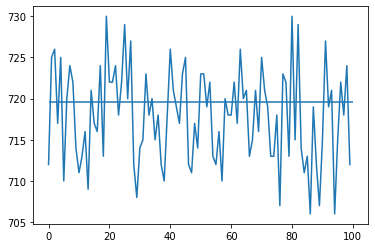

In [30]:
# The size of the partitions sligntly varies around 720 (~ 70% of the total observations) because for
# this kind of CV generator takes into account he imbalance in the data regarding the third-party tgroup 
# (in our case the twins info). See also https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
plt.plot([len(train_index) for train_index,_ in partition_idxs])
plt.hlines(xmin=0, xmax=100, y=0.7*n_subjects)

In [272]:
# Check that a family member is either in the training or the test set, but not in both
for i_fold, (train_index, test_index) in enumerate(partition_idxs):
    print(set(list(group_label[train_index])) & set(list(group_label[test_index])))

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


In [36]:
# Check that a family member is either in the training or the test set, but not in both
for i_fold, (train_index, test_index) in enumerate(partition_idxs):
    print("FOLD %d: twin members in training set also in test set?"% (i_fold +1),
          np.any(np.in1d(group_label[train_index], group_label[test_index])), ",",
          "twin member in test set also in training set?", 
          np.any(np.in1d(group_label[test_index], group_label[train_index])) 
         )

FOLD 1: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 2: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 3: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 4: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 5: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 6: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 7: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 8: twin members in training set also in test set? False , twin member in test set also in training set? False
FOLD 9: twin members in training set also in test set? False , twin member in te

In [37]:
proportion_family = {}
for family_id in np.unique(group_label):
    in_test = 0
    for _, test_index in partition_idxs:
        if family_id in group_label[test_index]:
            in_test +=1
            
    proportion_family[family_id] = (100-in_test)/100

In [36]:
# We can see that as minimum, one family is always in more of the folds in the training set
print(np.min(list(proportion_family.values())))
print(np.max(list(proportion_family.values())))

0.52
0.83


Store these partitions

In [37]:
with h5py.File(opj('../results', 'training_idxs_twinwise.hdf5'), 'a') as f_training_idxs:
    for i_fold, (train_index, _) in enumerate(partition_idxs):
        f_training_idxs.create_dataset('fold_%d' % (i_fold +1), 
                                       data = np.array(train_index))
        
with h5py.File(opj('../results', 'testing_idxs_twinwise.hdf5'), 'a') as f_test_idxs:
    for i_fold, (_, test_index) in enumerate(partition_idxs):
        f_test_idxs.create_dataset('fold_%d' % (i_fold +1), 
                                    data = np.array(test_index))

In [ ]:
# Construct single predictors classifiers
i_split = 0
seed = 0

single_r2_scores = np.zeros((n_splits, n_scores, n_mods +1)) # +1 to account for the confounders channel

neuro_comb_r2_scores = np.zeros((n_splits, n_scores))
comb_neuro_weights = np.zeros((n_splits, n_scores, n_mods)) 

comb_r2_scores = np.zeros((n_splits, n_scores))
comb_weights = np.zeros((n_splits, n_scores, n_mods + 1)) # +1 to account for the confounders channel

#Create empty dictionary for the predictions
preds_dict = {}
for score in score_names:
    preds_dict[score] = []
    
#compute starting execution time
start = time.time()    
for train_index, test_index in partition_idxs:

    YY_train = YY_domain_cognition[train_index]
    YY_test = YY_domain_cognition[test_index]
    
    # Regress out ICV from target variable
    YY_train_adj, YY_test_adj = regress_out(YY_train, 
                                            YY_test, 
                                            icv_var[train_index][:, np.newaxis], 
                                            icv_var[test_index][:, np.newaxis])
            
    for jj, score in enumerate(score_names):
            
        y_train = YY_train_adj[:, jj]
        y_test = YY_test_adj[:, jj]
        
        # Compute single predictions
        X_train_2, X_test_2 = first_stage_predictions([X_conn[train_index], 
                                                       X_surf[train_index], 
                                                       X_thic[train_index], 
                                                       X_subv[train_index], 
                                                       X_locc[train_index],
                                                       X_conf[train_index]], 
                                                      [X_conn[test_index], 
                                                       X_surf[test_index], 
                                                       X_thic[test_index], 
                                                       X_subv[test_index], 
                                                       X_locc[test_index],
                                                       X_conf[test_index]], y_train, y_test)     
        
        # Store single channel r2
        single_r2_scores[i_split, jj,:] = np.array([r2_score(y_test, X_test_2[:, kk]) \
                                                    for kk in range(n_mods + 1)]) # +1 to account for the confounders channel
        
        # Define Lasso second classifier (Require non-negativity of the weights)
        clf_2 = LassoCV(cv=5, random_state=RANDOM_STATE, positive=True)
        
        ### Find score of combining only neuroimaging measures ####
    
        # Fit on the stacked predictions
        clf_2.fit(X_train_2[:,:n_mods], y_train)
        
        # predict on the stacked predictions
        y_pred_neuro_comb = clf_2.predict(X_test_2[:,:n_mods])
        
        # Compute and store r2 for stacked predictions
        neuro_comb_r2_scores[i_split, jj] = r2_score(y_test, y_pred_neuro_comb)
        
        # Store the weights for each single prediction
        comb_neuro_weights[i_split, jj, :] = clf_2.coef_

        ### Find score of combining all neuroimaging measures ####
        
        # Fit on the stacked predictions
        clf_2.fit(X_train_2, y_train)
        
        # predict on the stacked predictions
        y_pred_comb = clf_2.predict(X_test_2)
        
        # Compute and store r2 for stacked predictions
        r2_comb = r2_score(y_test, y_pred_comb)
        comb_r2_scores[i_split, jj] = r2_comb
        
        # Store the weights for each single prediction
        comb_weights[i_split, jj, :] = clf_2.coef_
        
        #Create dataframe with the predictions
        preds_df = pd.DataFrame({'y_pred_conn': X_test_2[:, 0],
                                 'y_pred_surf': X_test_2[:, 1],
                                 'y_pred_thic': X_test_2[:, 2],
                                 'y_pred_subv': X_test_2[:, 3],
                                 'y_pred_locc': X_test_2[:, 4],
                                 'y_pred_conf': X_test_2[:, 5],
                                 'y_pred_neuro_comb': y_pred_neuro_comb,
                                 'y_pred_comb': y_pred_comb,
                                 'y_test': y_test}
                    )
        
        # Store this
        preds_dict[score].append(preds_df)
    
    print("split %d finished" % i_split)
    i_split = i_split + 1

# compute final execution time and elapsed time
done = time.time()
elapsed_time = done - start

split 0 finished
split 1 finished


Store these results and predictions into hdf5 files

In [71]:
with h5py.File(opj('../results', 'predictions_w_conf_hybrid_twins_R1.hdf5'), 'a') as f_preds:
    
    # Save predictions in each fold creating a 3D array where the first dimensions are the response variables,
    # the second dimension the observation and the third dimension the type of prediction
    for ii in range(n_splits):
        f_preds.create_dataset("fold_%d" % (ii+1), 
                               data = np.array([preds_dict[key][ii].to_numpy() for key in preds_dict.keys()])
                              )
        

In [47]:
f_res = h5py.File(opj('../results', 'scores_w_conf_hybrid_twins_R1.hdf5'), 'a')
f_res.create_dataset('comb_2_scores', data=comb_r2_scores)
f_res.create_dataset('neuro_comb_r2_scores', data=neuro_comb_r2_scores)
f_res.create_dataset('single_r2_scores', data=single_r2_scores)
f_res.create_dataset('comb_neuro_weights', data = comb_neuro_weights)
f_res.create_dataset('comb_weights', data = comb_weights)
f_res.close()

# RESPONSE TO REFEREE 1: Consider other factors for impulsivity and short penn

We here looked at one of the referees' suggestions of exploring other response variables, especially for the cases in which the effect sizes were small, as the variables that we used at first were maybe not that suitable for prediction. We tried the following:

- SCPT_TPRT = Short Penn CPT Median Response Time for True Positive Responses (Sustained attention)
- NEOFAC_E = NEO-FFI Extraversion Five Factor Model (NEO-FFI) Factor Summary Scores (Proxy for Impulsivity)

The latter variable was explicity suggested by the reviewer. We also considered the first one since in our original simulations, the distribution for the response variable used for sustained attention, Short Penn CPT sensitivity, had a large kurtosis and besides, the prediction accuracies were neglible. 

In [11]:
import os

misc_dir = "../results/misc"

if os.path.exists(misc_dir) is False:
    os.mkdir(misc_dir)

In [12]:
new_vars = ["SCPT_TPRT","NEOFAC_E"]

In [13]:
new_vars

['SCPT_TPRT', 'NEOFAC_E']

In [14]:
unrestricted_dat = pd.read_excel("../data/unrestricted_jraserod_8_16_2019_12_4_12.xlsx")

new_Y = pd.merge(unrestricted_dat, pd.DataFrame({"Subject":subjects}), on="Subject").loc[:, new_vars].values

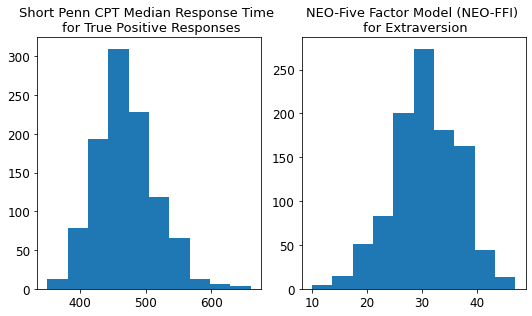

In [20]:
# We can see that the distribution for these new two variables look good enough
import matplotlib.pylab as plt


fig, axs = plt.subplots(ncols=2, figsize=(7.5, 4.5))
axs[0].hist(new_Y[:, 0])
axs[0].set_title("Short Penn CPT Median Response Time \n for True Positive Responses", size=13)
axs[0].tick_params(labelsize=12)
axs[1].hist(new_Y[:, 1])
axs[1].set_title("NEO-Five Factor Model (NEO-FFI) \n for Extraversion", size=13)
axs[1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(opj(misc_dir, "new_response_vars_distributions.png"), dpi=300)
plt.savefig(opj(misc_dir, "new_response_vars_distributions.svg"), dpi=300)

We are using the original training/test partitions, which guaranted that no statistical differences between the training and test set existed in the  response variables. Here it does not need to be true

In [39]:
for ii in range(2):
    ps = []
    for train_index, test_index in partition_idxs:
        d,p = ks_2samp(new_Y[train_index][:,ii], new_Y[test_index][:,ii])

        ps.append(p)
    
    print("number of partitions with no statistical differences between training and test for var %s = %i" % (new_vars[ii], sum(np.array(ps)>0.05)))

number of partitions with no statistical differences between training and test for var SCPT_TPRT = 92
number of partitions with no statistical differences between training and test for var NEOFAC_E = 97


Ok, so most of them are balanced. No need to further correct for this, especially after being using the median as the summary performance metric

In [40]:
# Construct single predictors classifiers
i_split = 0
seed = 0

new_single_r2_scores = np.zeros((n_splits, new_Y.shape[1], n_mods +1)) # +1 to account for the confounders channel

new_neuro_comb_r2_scores = np.zeros((n_splits, new_Y.shape[1]))
new_comb_neuro_weights = np.zeros((n_splits, new_Y.shape[1], n_mods)) 

new_comb_r2_scores = np.zeros((n_splits, new_Y.shape[1]))
new_comb_weights = np.zeros((n_splits, new_Y.shape[1], n_mods + 1)) # +1 to account for the confounders channel

#Create empty dictionary for the predictions
new_preds_dict = {}
for score in new_vars:
    new_preds_dict[score] = []
    
#compute starting execution time
start = time.time()    
for train_index, test_index in partition_idxs:

    YY_train = new_Y[train_index]
    YY_test = new_Y[test_index]
    
    # Regress out ICV from target variable
    YY_train_adj, YY_test_adj = regress_out(YY_train, 
                                            YY_test, 
                                            icv_var[train_index][:, np.newaxis], 
                                            icv_var[test_index][:, np.newaxis])
            
    for jj, score in enumerate(new_vars):
            
        y_train = YY_train_adj[:, jj]
        y_test = YY_test_adj[:, jj]
        
        # Compute single predictions
        X_train_2, X_test_2 = first_stage_predictions([X_conn[train_index], 
                                                       X_surf[train_index], 
                                                       X_thic[train_index], 
                                                       X_subv[train_index], 
                                                       X_locc[train_index],
                                                       X_conf[train_index]], 
                                                      [X_conn[test_index], 
                                                       X_surf[test_index], 
                                                       X_thic[test_index], 
                                                       X_subv[test_index], 
                                                       X_locc[test_index],
                                                       X_conf[test_index]], y_train, y_test)     
        
        # Store single channel r2
        new_single_r2_scores[i_split, jj,:] = np.array([r2_score(y_test, X_test_2[:, kk]) \
                                                    for kk in range(n_mods + 1)]) # +1 to account for the confounders channel
        
        # Define Lasso second classifier (Require non-negativity of the weights)
        clf_2 = LassoCV(cv=5, random_state=RANDOM_STATE, positive=True)
        
        ### Find score of combining only neuroimaging measures ####
    
        # Fit on the stacked predictions
        clf_2.fit(X_train_2[:,:n_mods], y_train)
        
        # predict on the stacked predictions
        y_pred_neuro_comb = clf_2.predict(X_test_2[:,:n_mods])
        
        # Compute and store r2 for stacked predictions
        new_neuro_comb_r2_scores[i_split, jj] = r2_score(y_test, y_pred_neuro_comb)
        
        # Store the weights for each single prediction
        new_comb_neuro_weights[i_split, jj, :] = clf_2.coef_

        ### Find score of combining all neuroimaging measures ####
        
        # Fit on the stacked predictions
        clf_2.fit(X_train_2, y_train)
        
        # predict on the stacked predictions
        y_pred_comb = clf_2.predict(X_test_2)
        
        # Compute and store r2 for stacked predictions
        r2_comb = r2_score(y_test, y_pred_comb)
        new_comb_r2_scores[i_split, jj] = r2_comb
        
        # Store the weights for each single prediction
        new_comb_weights[i_split, jj, :] = clf_2.coef_
        
        #Create dataframe with the predictions
        preds_df = pd.DataFrame({'y_pred_conn': X_test_2[:, 0],
                                 'y_pred_surf': X_test_2[:, 1],
                                 'y_pred_thic': X_test_2[:, 2],
                                 'y_pred_subv': X_test_2[:, 3],
                                 'y_pred_locc': X_test_2[:, 4],
                                 'y_pred_conf': X_test_2[:, 5],
                                 'y_pred_neuro_comb': y_pred_neuro_comb,
                                 'y_pred_comb': y_pred_comb,
                                 'y_test': y_test}
                    )
        
        # Store this
        new_preds_dict[score].append(preds_df)
    
    print("split %d finished" % i_split)
    i_split = i_split + 1

# compute final execution time and elapsed time
done = time.time()
elapsed_time = done - start

split 0 finished
split 1 finished
split 2 finished
split 3 finished
split 4 finished
split 5 finished
split 6 finished
split 7 finished
split 8 finished
split 9 finished
split 10 finished
split 11 finished
split 12 finished
split 13 finished
split 14 finished
split 15 finished
split 16 finished
split 17 finished
split 18 finished
split 19 finished
split 20 finished
split 21 finished
split 22 finished
split 23 finished
split 24 finished
split 25 finished
split 26 finished
split 27 finished
split 28 finished
split 29 finished
split 30 finished
split 31 finished
split 32 finished
split 33 finished
split 34 finished
split 35 finished
split 36 finished
split 37 finished
split 38 finished
split 39 finished
split 40 finished
split 41 finished
split 42 finished
split 43 finished
split 44 finished
split 45 finished
split 46 finished
split 47 finished
split 48 finished
split 49 finished
split 50 finished
split 51 finished
split 52 finished
split 53 finished
split 54 finished
split 55 finished
sp

In [41]:
new_y_scores = []
for ii in range(2):
    new_y_scores.append(list(np.median(new_single_r2_scores[:, ii, :n_mods], axis=0)) + [np.median(new_neuro_comb_r2_scores[:,ii])])

In [42]:
new_y_scores_df = pd.DataFrame(new_y_scores, columns=modality_names + ['STACKING'])
new_y_scores_df.index = new_vars
new_y_scores_df

,CONNECTOME,SURFACE,THICKNESS,SUB_VOLUMES,LOCAL_CONN,STACKING
SCPT_TPRT,-0.005574,-0.005623,-0.005367,-0.005318,-0.002642,-0.005512
NEOFAC_E,-0.004488,-0.005430,-0.006925,-0.004554,-0.004986,-0.007718


In [50]:
with h5py.File("../results/misc/new_scores_results.hdf5", "w") as f:
    f.create_dataset('short_penn_median_time', data=new_y_scores[0])
    f.create_dataset('neofac_extraversion', data=new_y_scores[1])

# REVIEWER 3: SINGLE GRAND LASSO-PCR (ALL DATA TOGETHER)

In [18]:
from sklearn.pipeline import make_pipeline

In [19]:
XX_single = np.column_stack((X_conn, X_surf, X_thic, X_subv, X_locc))

In [20]:
print("The concatenated data has dimensions =", XX_single.shape)

The concatenated data has dimensions = (1028, 387082)


In [21]:
yy = YY_domain_cognition[:, 0] # Just use Global Cognitive Function

In [22]:
pip = make_pipeline(VarianceThreshold(), StandardScaler(), PCA(), LassoCV(max_iter = 1e6, cv = 5, n_jobs=-1, random_state = 0))

In [34]:
r2_global_single_grand_lasso = []
i_split=0
for train_index, test_index in partition_idxs:
    
    XX_single_train, XX_single_test = XX_single[train_index], XX_single[test_index]
    
    yy_train = yy[train_index]
    yy_test = yy[test_index]
    
    icv_train = icv_var[train_index]
    icv_test = icv_var[test_index]
    
    # Remove ICV effects
    linReg = LinearRegression()
    linReg.fit(icv_train[:, np.newaxis], yy_train)
    yy_train_adj = yy_train - linReg.predict(icv_train[:, np.newaxis]) + linReg.intercept_
    yy_test_adj = yy_test - linReg.predict(icv_test[:, np.newaxis]) + linReg.intercept_
    
    # Train
    pip.fit(XX_single_train, yy_train_adj)
    # Predict
    r2  = pip.score(XX_single_test, yy_test_adj)
    
    r2_global_single_grand_lasso.append(r2)
    
    
    i_split = i_split + 1
    print(np.round(r2,3))
    print("split %d finished" % i_split)

0.06
split 1 finished
0.042
split 2 finished
0.058
split 3 finished
0.046
split 4 finished
0.038
split 5 finished
0.058
split 6 finished
0.028
split 7 finished
0.067
split 8 finished
0.046
split 9 finished
0.052
split 10 finished
0.081
split 11 finished
0.073
split 12 finished
0.053
split 13 finished
0.045
split 14 finished
0.052
split 15 finished
0.028
split 16 finished
0.056
split 17 finished
0.085
split 18 finished
0.052
split 19 finished
0.036
split 20 finished
0.087
split 21 finished
0.049
split 22 finished
0.074
split 23 finished
0.052
split 24 finished
0.022
split 25 finished
0.041
split 26 finished
0.03
split 27 finished
0.059
split 28 finished
0.068
split 29 finished
0.039
split 30 finished
0.043
split 31 finished
0.058
split 32 finished
0.07
split 33 finished
0.026
split 34 finished
0.044
split 35 finished
0.042
split 36 finished
0.046
split 37 finished
0.017
split 38 finished
0.065
split 39 finished
0.035
split 40 finished
0.061
split 41 finished
0.043
split 42 finished
0.06

In [35]:
from matplotlib.cbook import boxplot_stats

np.random.seed(0)
for key, value in boxplot_stats(r2_global_single_grand_lasso, bootstrap=1000)[0].items():
    print(key, " = ", np.round(value, 3))

mean  =  0.047
iqr  =  0.026
cilo  =  0.044
cihi  =  0.052
whishi  =  0.092
whislo  =  0.001
fliers  =  [-0.005]
q1  =  0.034
med  =  0.047
q3  =  0.06


In [38]:
with h5py.File("../results/misc/single_grand_lasso_global_cognition_scores.hdf5", "w") as f:
    f.create_dataset('single_grand_lasso_global_cognition_scores', data=r2_global_single_grand_lasso)